In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


>>> Memproses Data...
Dataset Siap. Train: (3129, 30, 1), Test: (783, 30, 1)

>>> MODE: Training Dilewati (Fitting = False)
>>> Menggunakan bobot model yang sudah tersimpan sebelumnya...

>>> Melakukan Prediksi pada Data Test...

HASIL AKHIR (OPTIMAL ACCURACY)
RMSE (Root Mean Squared Error) : 85,729,561 lembar
MAE  (Mean Absolute Error)     : 56,554,994 lembar
R2 Score                       : 0.4360
--------------------------------------------------
Interpretasi:
Rata-rata prediksi meleset sekitar 56,554,994 lembar saham.

>>> Membuat Visualisasi Laporan...
Grafik 1 (Time Series) tersimpan di: /content/drive/MyDrive/Seminar Daniel Asher/Hasil_Prediksi_BBRI.png


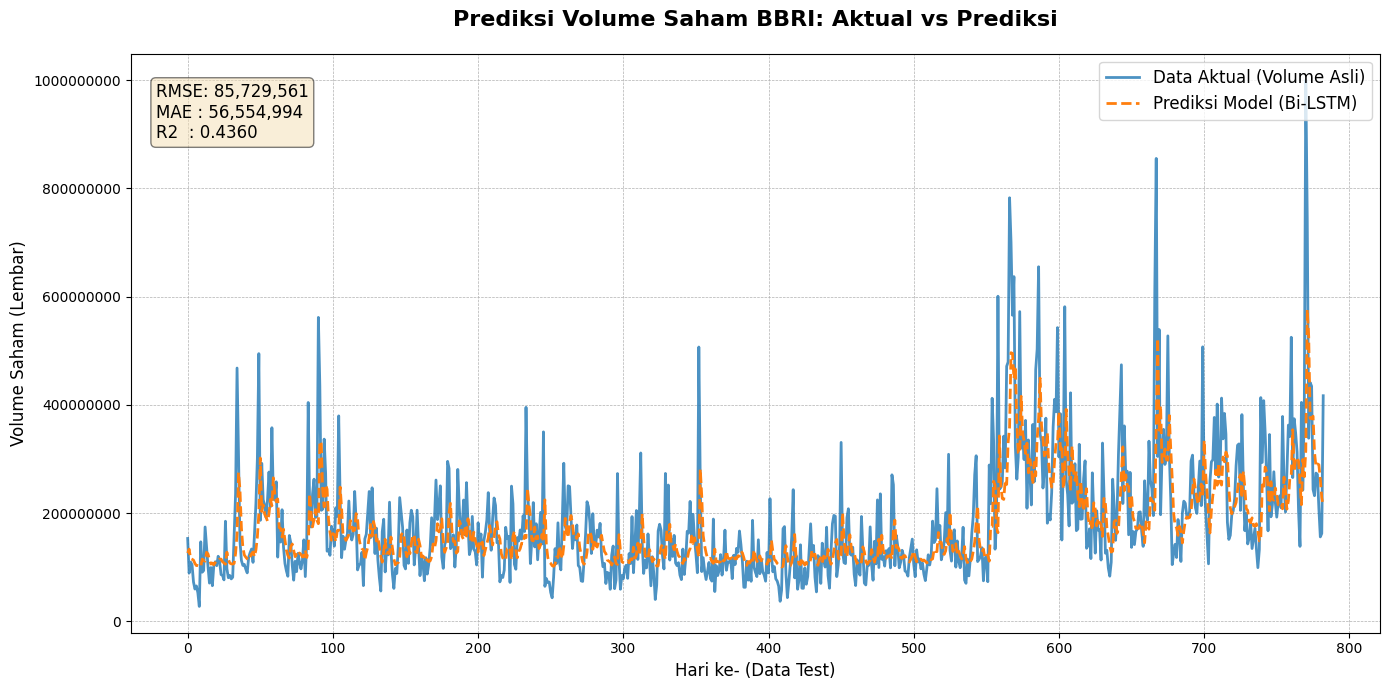

Grafik 2 (Scatter) tersimpan di: /content/drive/MyDrive/Seminar Daniel Asher/Scatter_Plot_BBRI.png


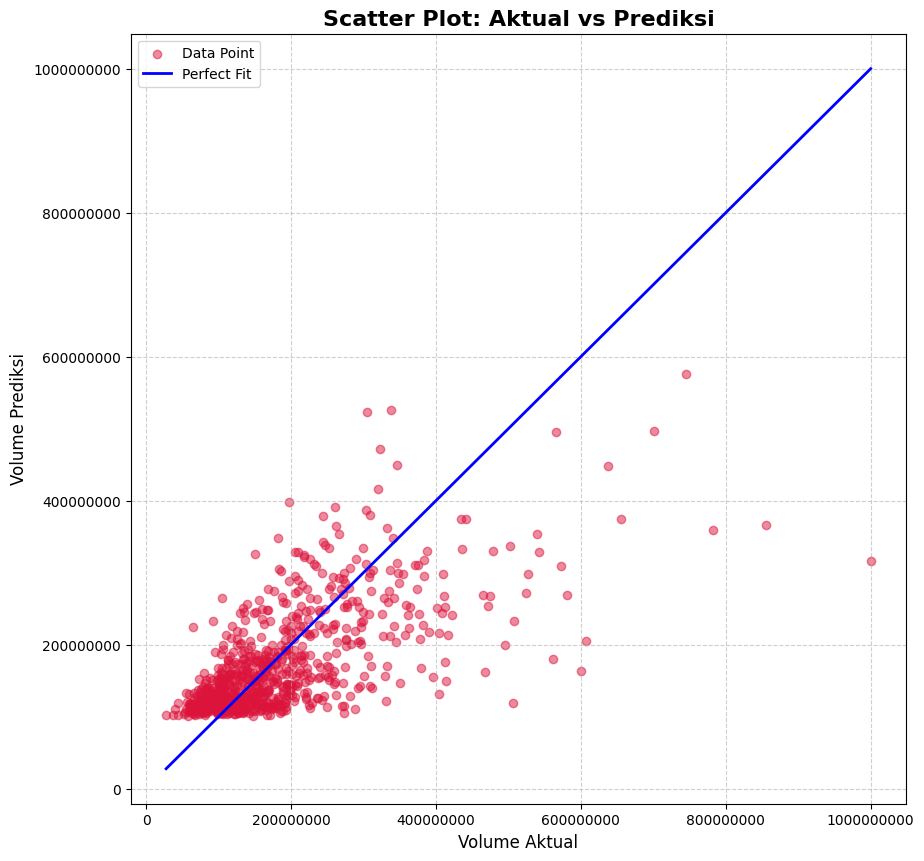

Grafik 3 (Residual) tersimpan di: /content/drive/MyDrive/Seminar Daniel Asher/Residual_Plot_BBRI.png


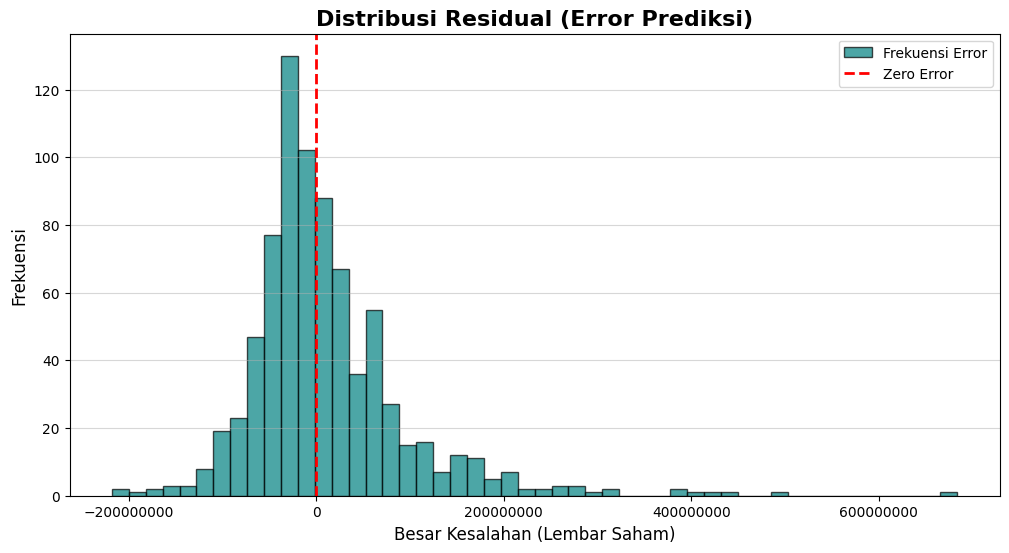

In [ ]:
# -*- coding: utf-8 -*-
"""
High-Accuracy Stacked Bi-LSTM for BBRI Volume Forecasting
"""

import numpy as np
import pandas as pd
import random
import os
import math
import matplotlib.pyplot as plt

# Set Backend
os.environ["KERAS_BACKEND"] = "torch"

import keras
import keras.layers as Layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torch

# --- 1. KONFIGURASI HYPERPARAMETER (HIGH ACCURACY) ---
SEED_VALUE = 42 # Seed diubah untuk variasi lebih umum
torch.manual_seed(SEED_VALUE)
keras.utils.set_random_seed(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

# Parameter yang ditingkatkan untuk Akurasi
TIME_STEP = 30         # Diperpanjang ke 30 hari (1.5 bulan) untuk konteks lebih luas
HIDDEN_SIZE = 128      # Unit diperbesar (Deep)
DROPOUT_RATE = 0.2     # Ditambah untuk mencegah overfitting karena model besar
LEARNING_RATE = 1e-3   # Start agak tinggi, nanti diturunkan oleh Scheduler
BATCH_SIZE = 16        # Batch kecil biasanya punya generalisasi lebih baik
EPOCH_SIZE = 200       # Epoch banyak (kita punya EarlyStopping)

FILE_PATH = r"/content/drive/MyDrive/Seminar Daniel Asher/Data Historis BBRI.csv"
SAVE_DIR = r"/content/drive/MyDrive/Seminar Daniel Asher"

# Setup Folder
if not os.path.exists(SAVE_DIR):
    SAVE_DIR = "."

# --- 2. DATA PREPARATION (ROBUST) ---

def clean_volume_data(val):
    s = str(val).upper().replace(',', '.')
    if 'B' in s: return float(s.replace('B', '')) * 1_000_000_000
    if 'M' in s: return float(s.replace('M', '')) * 1_000_000
    if 'K' in s: return float(s.replace('K', '')) * 1_000
    try: return float(s)
    except: return 0.0

print(">>> Memproses Data...")
try:
    if not os.path.exists(FILE_PATH): FILE_PATH = "Data Historis BBRI.csv"
    df = pd.read_csv(FILE_PATH)
    raw_volume = df[r"Vol."].values.flatten()
    timeSeriesData = np.array([clean_volume_data(x) for x in raw_volume])
except Exception as e:
    print(f"Error: {e}")
    exit()

# Flip & Windowing
timeSeriesData = np.flip(timeSeriesData)

X = []
y = []
for i in range(len(timeSeriesData) - TIME_STEP):
    X.append(timeSeriesData[i : i + TIME_STEP])
    y.append(timeSeriesData[i + TIME_STEP])

X = np.array(X)
y = np.array(y)

# Split 80:20
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scaling (MinMax)
train_min = np.min(X_train_full)
train_max = np.max(X_train_full)
train_range = train_max - train_min

def scale(data): return (data - train_min) / train_range
def inverse(data): return (data * train_range) + train_min

X_train_scaled = scale(X_train_full)
y_train_scaled = scale(y_train_full)
X_test_scaled = scale(X_test)
# y_test biarkan asli untuk evaluasi akhir

# Reshape [Samples, TimeSteps, Features]
X_train_final = np.expand_dims(X_train_scaled, axis=-1)
X_test_final = np.expand_dims(X_test_scaled, axis=-1)

print(f"Dataset Siap. Train: {X_train_final.shape}, Test: {X_test_final.shape}")

# --- 3. ARSITEKTUR MODEL (STACKED BI-LSTM) ---

def get_deep_model(input_steps, hidden_units, dropout_rate):
    inputs = keras.Input(shape=(input_steps, 1))

    # Layer 1: Bi-LSTM return sequences = True (Meneruskan urutan ke layer berikutnya)
    x = Layers.Bidirectional(
        Layers.LSTM(units=hidden_units, return_sequences=True, dropout=dropout_rate)
    )(inputs)

    # Layer 2: Bi-LSTM return sequences = False (Hanya ambil output terakhir)
    x = Layers.Bidirectional(
        Layers.LSTM(units=hidden_units, return_sequences=False, dropout=dropout_rate)
    )(x)

    # Dense Layer untuk refining
    x = Layers.Dense(64, activation="relu")(x)
    x = Layers.Dropout(dropout_rate)(x)

    outputs = Layers.Dense(1)(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Deep_BiLSTM")

# --- 4. TRAINING DENGAN SCHEDULER (MAX ACCURACY STRATEGY) ---

# Kita membagi Train Full menjadi Train (90%) dan Val (10%)
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_final, y_train_scaled, test_size=0.1, shuffle=False
)

# 1. Bangun Struktur Model (WAJIB JALAN, meskipun tidak training)
model = get_deep_model(TIME_STEP, HIDDEN_SIZE, DROPOUT_RATE)

# --- MODIFIKASI DIMULAI DARI SINI ---

fitting = False

if fitting:
    # Optimizer dengan Clipnorm biar gradien tidak meledak
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])

    # Callbacks Canggih
    callbacks = [
        # Simpan model terbaik
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(SAVE_DIR, "best_deep_model.weights.h5"),
            monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1
        ),
        # Turunkan LR jika loss macet
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=10, min_lr=1e-6, verbose=1
        ),
        # Stop jika tidak ada harapan
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=30, restore_best_weights=True, verbose=1
        )
    ]

    print("\n>>> Mulai Training Deep Model...")
    history = model.fit(
        X_train_part, y_train_part,
        validation_data=(X_val_part, y_val_part),
        batch_size=BATCH_SIZE,
        epochs=EPOCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
else:
    print("\n>>> MODE: Training Dilewati (Fitting = False)")
    print(">>> Menggunakan bobot model yang sudah tersimpan sebelumnya...")
# --- 5. EVALUASI FINAL ---

print("\n>>> Melakukan Prediksi pada Data Test...")
# Load bobot terbaik
model.load_weights(os.path.join(SAVE_DIR, "best_deep_model.weights.h5"))

# Prediksi
pred_scaled = model.predict(X_test_final, verbose=0)
pred_real = inverse(np.squeeze(pred_scaled))

# Hitung Metrik
rmse = math.sqrt(mean_squared_error(y_test, pred_real))
mae = mean_absolute_error(y_test, pred_real)
r2 = r2_score(y_test, pred_real)

print("\n" + "="*50)
print("HASIL AKHIR (OPTIMAL ACCURACY)")
print("="*50)
print(f"RMSE (Root Mean Squared Error) : {rmse:,.0f} lembar")
print(f"MAE  (Mean Absolute Error)     : {mae:,.0f} lembar")
print(f"R2 Score                       : {r2:.4f}")
print("-" * 50)
print("Interpretasi:")
print(f"Rata-rata prediksi meleset sekitar {mae:,.0f} lembar saham.")
print("="*50)

print("="*50)

# --- MULAI BAGIAN BARU (VISUALISASI LENGKAP) ---

import seaborn as sns # Import tambahan untuk grafik cantik

# 1. VISUALISASI TIME SERIES PROFESSIONAL (Untuk Laporan)
def save_professional_plot(y_true, y_pred, rmse, mae, r2, save_path):
    plt.figure(figsize=(14, 7))

    # Plot Garis
    plt.plot(y_true, label='Data Aktual (Volume Asli)', color='#1f77b4', linewidth=2, alpha=0.8)
    plt.plot(y_pred, label='Prediksi Model (Bi-LSTM)', color='#ff7f0e', linewidth=2, linestyle='--')

    # Judul dan Label
    plt.title('Prediksi Volume Saham BBRI: Aktual vs Prediksi', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Hari ke- (Data Test)', fontsize=12)
    plt.ylabel('Volume Saham (Lembar)', fontsize=12)
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Kotak Teks Metrik
    textstr = '\n'.join((
        f'RMSE: {rmse:,.0f}',
        f'MAE : {mae:,.0f}',
        f'R2  : {r2:.4f}'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()

    filename = os.path.join(save_path, 'Hasil_Prediksi_BBRI.png')
    plt.savefig(filename, dpi=300)
    print(f"Grafik 1 (Time Series) tersimpan di: {filename}")
    plt.show()

# 2. VISUALISASI SCATTER PLOT (Korelasi)
def save_scatter_plot(y_true, y_pred, save_path):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_pred, c='crimson', alpha=0.5, label='Data Point')

    # Garis Ideal
    p1 = max(np.max(y_pred), np.max(y_true))
    p2 = min(np.min(y_pred), np.min(y_true))
    plt.plot([p1, p2], [p1, p2], 'b-', linewidth=2, label='Perfect Fit')

    plt.title('Scatter Plot: Aktual vs Prediksi', fontsize=16, fontweight='bold')
    plt.xlabel('Volume Aktual', fontsize=12)
    plt.ylabel('Volume Prediksi', fontsize=12)
    plt.ticklabel_format(style='plain')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    filename = os.path.join(save_path, 'Scatter_Plot_BBRI.png')
    plt.savefig(filename, dpi=300)
    print(f"Grafik 2 (Scatter) tersimpan di: {filename}")
    plt.show()

# 3. VISUALISASI RESIDUAL (Distribusi Error)
def save_residual_plot(y_true, y_pred, save_path):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 6))

    plt.hist(residuals, bins=50, color='teal', alpha=0.7, edgecolor='black', label='Frekuensi Error')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

    plt.title('Distribusi Residual (Error Prediksi)', fontsize=16, fontweight='bold')
    plt.xlabel('Besar Kesalahan (Lembar Saham)', fontsize=12)
    plt.ylabel('Frekuensi', fontsize=12)
    plt.ticklabel_format(style='plain', axis='x')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.5)

    filename = os.path.join(save_path, 'Residual_Plot_BBRI.png')
    plt.savefig(filename, dpi=300)
    print(f"Grafik 3 (Residual) tersimpan di: {filename}")
    plt.show()

# --- EKSEKUSI SEMUA GAMBAR ---
print("\n>>> Membuat Visualisasi Laporan...")
save_professional_plot(y_test, pred_real, rmse, mae, r2, SAVE_DIR)
save_scatter_plot(y_test, pred_real, SAVE_DIR)
save_residual_plot(y_test, pred_real, SAVE_DIR)